In [1]:
%load_ext autoreload
%autoreload 2

In [62]:
import os
import json

import pandas as pd

from src import visualization, active_learning

Alright, let's see what the results are.

In [63]:
results = {}
for file in os.listdir('./results'):
    name = '_'.join(file.split('_')[:2])
    with open(os.path.join('./results', file), 'r') as f:
        results[name] = json.load(f)

# Accuracy vs budget curves

This graph shows how the training process was going for every model. It can help visually compair their performance.

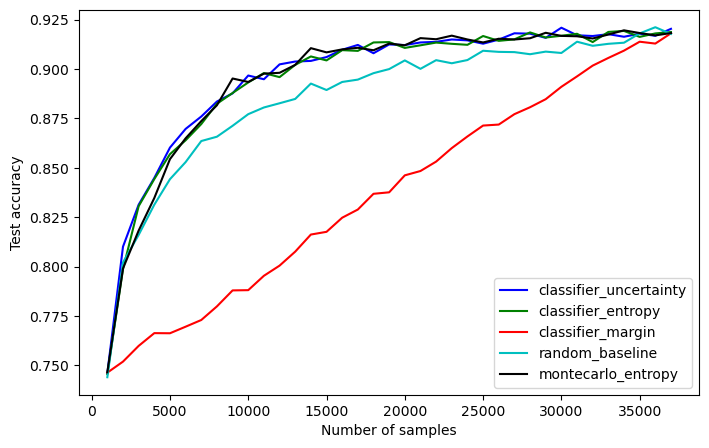

In [64]:
visualization.plot_accuracy_budget_curves(results)

It is surprising, that margin performs so poorly (even random baseline is decent).

Theory: issue is the library I am using. For entropy and uncertainty we need to pick the highest score, but for margin - the lowest. If library doesn't inverse scores, then I am actually adding samples on which the model is most certain.

Performance of uncertainty, entropy and entropy with montecarlo dropout seems comparable.

# Highest accuracy achieved

Next what I want to see is what was the highest accuracy achieved with every sampling strategy and with what budget.

In [65]:
accuracy_data = {}
for name, data in results.items():
    max_accuracy, best_budget = active_learning.max_accuracy(data)
    accuracy_data[name] = {
        'accuracy': max_accuracy,
        'budget': best_budget,
    }
pd.DataFrame(accuracy_data).T

,accuracy,budget
classifier_uncertainty,0.920878,30000
classifier_entropy,0.919248,34000
classifier_margin,0.918056,37000
random_baseline,0.921129,36000
montecarlo_entropy,0.919561,34000


Random baseline wins! Though, the highest accuracy was achieved on almost full dataset for all strategies, so it is not very important for active learning comparison.

Looking and accuracy vs budget curves we can see, that best performing models rise up quickly and start meandering, going up and down. For this reason it doesn't make much sense to analyse all 36 steps. So next I will divide analysis into two parts:

1. First 10 steps of active learning. It is time when performance quickly goes up and models compete with each other on achieving better performance on smaller budget.
2. First 20 steps of active learning. During this step performance of models sometimes go down, but overall is getting close to the highest possible one.

# First 10 steps of active learning

First I need to reduce the data.

In [66]:
results_10 = {}
for name, data in results.items():
    results_10[name] = {}
    for i, key in enumerate(data):
        results_10[name][key] = data[key]
        if i >=10:
            break

## Highest achieved accuracy

In [67]:
accuracy_data = {}
for name, data in results_10.items():
    max_accuracy, best_budget = active_learning.max_accuracy(data)
    accuracy_data[name] = {
        'accuracy': max_accuracy,
        'budget': best_budget,
    }
pd.DataFrame(accuracy_data).T

,accuracy,budget
classifier_uncertainty,0.896677,10000
classifier_entropy,0.897931,11000
classifier_margin,0.795298,11000
random_baseline,0.880502,11000
montecarlo_entropy,0.897618,11000


Classical entropy achieves the highest performance, but montecarlo entropy is close by.

## Area under budget curve

This metric represents how close our models performance to the ideal model (which is always right from the start) and how quickly rises its performance. Higher the better.

In [68]:
aubc_data = {}
for name, data in results_10.items():
    area = active_learning.area_under_budget_curve(data)
    aubc_data[name] = {
        'AUBC': area
    }
pd.DataFrame(aubc_data).T

,AUBC
classifier_uncertainty,0.858019
classifier_entropy,0.855138
classifier_margin,0.771310
random_baseline,0.843618
montecarlo_entropy,0.853696


Uncertainty strategy rises in performance faster than other methods (classical entropy is the second).

## True performance of the selection strategy

If sampling strategy is good, model's performance would not only rise quickly, but also would not go down during active learning steps (because model only receives samples that are very informative to it).

*True performance of the selection strategy* tries to take this into account by calculating difference between areas under curve where performance of the model rises and those, where it falls down, multiplied by the performance change itself (I know, sounds convoluted, but if you look at the paper or at the code, it is quite straightforward).

In [69]:
tp_data = {}
for name, data in results_10.items():
    strategy_perf = active_learning.selection_strategy_performance(data)
    tp_data[name] = {
        'True performance': strategy_perf
    }
pd.DataFrame(tp_data).T

,True performance
classifier_uncertainty,0.115556
classifier_entropy,0.130335
classifier_margin,0.034098
random_baseline,0.115197
montecarlo_entropy,0.116711


Here we can see, that during first 10 steps classical entropy only improves performance, that's why it has the highest score.

# First 20 steps of active learning

In [70]:
results_20 = {}
for name, data in results.items():
    results_20[name] = {}
    for i, key in enumerate(data):
        results_20[name][key] = data[key]
        if i >=20:
            break

## Highest achieved accuracy

In [71]:
accuracy_data = {}
for name, data in results_20.items():
    max_accuracy, best_budget = active_learning.max_accuracy(data)
    accuracy_data[name] = {
        'accuracy': max_accuracy,
        'budget': best_budget,
    }
pd.DataFrame(accuracy_data).T

,accuracy,budget
classifier_uncertainty,0.913417,21000
classifier_entropy,0.913605,19000
classifier_margin,0.848339,21000
random_baseline,0.904326,20000
montecarlo_entropy,0.915611,21000


Here montecarlo entropy gets to be on top, but not by a high margin.

## Area under budget curve

In [72]:
aubc_data = {}
for name, data in results_20.items():
    area = active_learning.area_under_budget_curve(data)
    aubc_data[name] = {
        'AUBC': area
    }
pd.DataFrame(aubc_data).T

,AUBC
classifier_uncertainty,0.882741
classifier_entropy,0.881064
classifier_margin,0.797533
random_baseline,0.868301
montecarlo_entropy,0.880878


Uncertainty still shows the steepest rise, but difference between contenders is smaller.

## True performance of the selection strategy

In [73]:
tp_data = {}
for name, data in results_20.items():
    strategy_perf = active_learning.selection_strategy_performance(data)
    tp_data[name] = {
        'True performance': strategy_perf
    }
pd.DataFrame(tp_data).T

,True performance
classifier_uncertainty,0.128879
classifier_entropy,0.120338
classifier_margin,0.077538
random_baseline,0.126740
montecarlo_entropy,0.121453


Uncertainty is clearly the best by this metric, but second best is random baseline (because its performance goes up and down less).